In [47]:
import numpy as np
import matplotlib.pyplot as plt


In [48]:

class MLFF(object):
    def __init__(self,d1 = 27,weight_initializer = 'random'):
        """
        a 3-layer MLFF network:  d input,  2*d+1 neuron in one hidden layer, 1 output neuron
        """
        d2 = d1 * 2 + 1
        self.d1 = d1
        self.d2 = d2
        # list of activation function
        self.activate = [None]
        # list of activation function derivative
        self.derivative=[None]
        # Layer 1
        # w1: the weights between input layer and hidden layer
        # with shape of d2 rows x d1 columns.
        # Each row of w1 represents the weigths associated with a neuron in hidden layer
        # After adding bias, there are  d2*(d1+1) weights connecting input layer to hidden layer
        if weight_initializer == 'random':
            nums = np.round(np.random.random((d1+1) * d2)-np.random.random((d1+1) * d2), 3)*10
        else:
            nums = [0.0] * ((d1 + 1) * d2)
        self.w1 = np.array(nums).reshape([d2,(d1+1)])
#         self.activate.append(self.logistic)
#         self.derivative.append(self.derivative_logistic)
        
        self.activate.append(self.relu)
        self.derivative.append(self.d_relu)
        
        
        # Layer 2:
        # w2: the weights between hidden layer and output layer
        # there are d2 number of weight , plus one bias. Hence there are d2+1 weights
        if weight_initializer == 'random':
            nums = np.round(np.random.random(d2+1) - np.random.random(d2+1),3)*10
        else:
            nums = [0.0]*(d2+1)
        self.w2 = np.array(nums)
        self.activate.append(self.logistic)
        self.derivative.append(self.d_logistic)

    def logistic(self, net):
        k = 0.01
        return 1/(1+ np.exp(-k*net))
    
    def d_logistic(self,net,out):
        """
        out: numpy array
        """
        k = 0.01
#         return k*np.exp(-k*net)/np.square(1+ np.exp(-k*net))
        return k*out*(1.0- out)


    def relu(self,net):
        k =1.0
        k1= 0.5
        ma = k*np.maximum(net, np.zeros(np.shape(net)))
        mi = k1*np.minimum(net, np.zeros(np.shape(net)))
        return ma+mi

    def d_relu(self, net,o):
        k = 1.0
        k1 = 0.5
        z = np.zeros(np.shape(net))
        m = np.maximum(z,net)
        deriv = np.where(m>0.0,k,m)
        deriv = np.where(deriv==0.0,k1,deriv)
        return deriv

    
    def tanh(self,net):
        return np.tanh(net)
    
    def d_tanh(self,net,o):
        return 1.0-np.square(o)
    
def load_data():
    fp = open('db4_Diff1f_100_128w_AEP2_gp2_ver1-1_ece856.txt','r+')
    lines = fp.readlines()
    input = []
    target = []
    for line in lines:
        line = line.split('\n')[0]

        data=[float(s) for s in line.split(' ') if s!='']
        input.append(data)
        target.append(1)
    fp.close()

    fp = open('db4_Diff1f_100_128w_nonAEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        data=[float(s) for s in line.split(' ') if s != '']
        input.append(data)
        target.append(0)
    fp.close()
    print("shape",np.shape(input),np.shape(target))
    return np.array(target), np.array(input)



In [49]:
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
class Smote:
    def __init__(self,samples,N=10,k=5):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N/100)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)  
#         print ('neighbors',neighbors)
        for i in range(len(self.samples)):
#             print('samples',self.samples[i])
            nnarray=neighbors.kneighbors(self.samples[i].reshape((1,-1)),return_distance=False)[0]  #Finds the K-neighbors of a point.
#             print ('nna',nnarray)
            self._populate(N,i,nnarray)
        return self.synthetic


    # for each minority class sample i ,choose N of the k nearest neighbors and generate N synthetic samples.
    def _populate(self,N,i,nnarray):
        for j in range(N):
#             print('j',j)
            nn=random.randint(0,self.k-1)  #包括end
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1
#             print(self.synthetic)
            
# a=np.array([[1,2,3],[4,5,6],[2,3,1],[2,1,2],[2,3,4],[2,3,4]])
# s=Smote(a,N=200)
# n= s.over_sampling()
# print(np.shape(n))

In [50]:

def save_balanced_data( train_i,train_t,test_i,test_t):
    fp = open('balanced_train_v2.txt','w+')
    for i in range(len(train_i)):
        d_str = str(train_t[i]) + '\t' +str(train_i[i,:])[1:-1] +'\n'
        fp.write(d_str)
    fp.close()

    fp = open('testset_v2.txt', 'w+')
    for i in range(len(test_i)):
        d_str = str(test_t[i]) + '\t' + str(test_i[i, :])[1:-1] + '\n'
        fp.write(d_str)
    fp.close()

    pass


def balance_data(aep_i,aep_t, non_aep_i,non_aep_t,method ='downsampling', test_aep_sample= 30,test_nonaep_sample= 1200):
    """

    :param aep_i:
    :param aep_t:
    :param non_aep_i:
    :param non_aep_t:
    :param method:
    :param test_aep_sample:
    :param test_nonaep_sample:
    :return:
    """

    # split test set and train set
    test_aep_sample = int(0.3*len(aep_i))
    
    aep_test_i = aep_i[0:test_aep_sample,:]
    aep_test_t = aep_t[0:test_aep_sample]
    test_nonaep_sample = int(0.3*len(non_aep_i))
    non_aep_test_i = non_aep_i[0:test_nonaep_sample,:]
    non_aep_test_t = non_aep_t[0:test_nonaep_sample]

    # test set
    test_i = np.concatenate((aep_test_i,non_aep_test_i),axis=0)
    test_t = []
    test_t.extend(aep_test_t)
    test_t.extend( non_aep_test_t)

    # train set
    aep_i =aep_i[test_aep_sample:,:]
    aep_t = np.array(aep_t[test_aep_sample:])
    non_aep_i = non_aep_i[test_nonaep_sample:, :]
    non_aep_t = non_aep_t[test_nonaep_sample:]

 
    # balance training set here
    if method == 'oversampling':
        sample_range = len(aep_i)
        indices = np.random.randint(sample_range, size=len(non_aep_i))
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i, non_aep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(non_aep_t)


    elif method == 'downsampling':
        sample_range = len(non_aep_i)
        indices = np.random.randint(sample_range, size=len(aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        
        train_i = np.concatenate((aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(aep_t)
        train_t.extend(new_nonaep_t)
        pass
    elif method == 'SMOTE':
        
        s= Smote(aep_i,N=10*int(5000/len(aep_i)))
        new_aep_i = s.over_sampling()
        new_aep_t = [1.0]*len(new_aep_i)
        indices = np.random.randint(len(non_aep_i), size=len(new_aep_i))
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
    else:
        sample_size = 500
        indices = np.random.randint(len(non_aep_i), size=sample_size)
        new_nonaep_i = non_aep_i[indices,:]
        new_nonaep_t = non_aep_t[indices]
        indices = np.random.randint(len(aep_i), size=sample_size)
        new_aep_i = aep_i[indices,:]
        new_aep_t = aep_t[indices]
        
        train_i = np.concatenate((new_aep_i,new_nonaep_i),axis=0)
        train_t =[]
        train_t.extend(new_aep_t)
        train_t.extend(new_nonaep_t)
        pass


    return train_i,train_t,test_i,test_t



def load_balanced_data(method='SMOTE'):
    fp = open('db4_Diff1f_100_128w_AEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    aep_i = []
    aep_t = []
    non_aep_i = []
    non_aep_t = []

    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        aep_i.append(data)
        aep_t.append(1)
    fp.close()

    aep_i = np.array(aep_i)
    aep_t = np.array(aep_t)

    fp = open('db4_Diff1f_100_128w_nonAEP2_gp2_ver1-1_ece856.txt', 'r+')
    lines = fp.readlines()
    for line in lines:
        line = line.split('\n')[0]
        data = [float(s) for s in line.split(' ') if s != '']
        non_aep_i.append(data)
        non_aep_t.append(0)
    fp.close()
    non_aep_i = np.array(non_aep_i)
    non_aep_t = np.array(non_aep_t)

#     train_i, train_t, test_i, test_t= balance_data(aep_i,aep_t,non_aep_i,non_aep_t,method='downsampling')
    train_i, train_t, test_i, test_t= balance_data(aep_i,aep_t,non_aep_i,non_aep_t,method=method)
    save_balanced_data(train_i, train_t, test_i, test_t)
    train_i, train_t, test_i, test_t = np.array(train_i),np.array(train_t),np.array(test_i),np.array(test_t)
    return train_i, train_t, test_i, test_t


In [51]:

def feedforward(i,model,bias = False):
    """

    :param i: a 1-D array input vector with shape (27,) 
    :param model: multi-layer feedforward network model
    :param bias: a flag indicating if bias should be used
    :return:
        input: 1-D array, including bias
        o1: 1-D array, intermmediate output from hidden layer, it includes the bias. o1 have shape
        output:a scalar value,  the output of neural network, it is a scalar value.  
        For this dx(2d+1)x 1 neural network, the output represents the possibility whether the input is AEP
    """
    output = 0.0
    input = np.zeros(len(i) + 1)
    input[1:] = i
    if bias:
        input[0] = 1.0
    i = input.reshape((len(i) + 1,1))
    # i shape:  n x 1 , vector
    net_1= np.matmul(model.w1, i)
    # activation of hidden layer, s1: nx1 vector
    s1 =model.activate[1](net_1)
    
    #print("s1 shape:",np.shape(s1))

    # add feature x0 =1 to intermediate output if bias is enabled
    # o1 is 1-D array
    o1= np.zeros(len(s1)+1)
    #print("o1 shape:",np.shape(o1))
    o1[1:]= s1[:,0]
    if bias:
        o1[0] = 1.0

    # output layer
    net_2 = np.dot(o1, model.w2)
    # output of MLFF
    output = model.activate[2](net_2)

    return input, o1, output


def backforward(model,o0,o1,o2,t):
    """
    :param model:  a model object storing all weights 
    :param o0: 1-D array
    :param o1: 1-D array
    :param o2: a scalar value from output layer
    :param t: target, a scalar value
    :return:
        delta_1: a scalar value
        delta_2: a 1-D array
    """
    ## output layer:
    # dE/do = (t-o)
    diff = t-o2
    dE_o2 = -diff
    # do/dnet = o(1-o) for logistic function,  a scalar value
    dO_net =model.derivative[2](None,o2)

    # dnet/w = o1
    # delta = (t-o)*f'(net)= - dE/do * f'(net), a scalar value
    delta2 = -dE_o2 * dO_net

    # hidden layer :
    # Do not back-propagate bias in hidden layer,  to the last layer
    # model.w2[0] is the bias between hidden layer and output layer
    # model.w2[1:]: 1-D array
    dE_o1 = -delta2 * model.w2
    dE_o1 =  dE_o1[1:]
    o1 = o1[1:]
    
    dO1_net = model.derivative[1](np.dot(model.w1,o0),o1)
        
    delta1 = -dE_o1* dO1_net
    
    return delta1,delta2



def predict(inputs,model,bias=False):
    pred = []
    for i in range(len(inputs)):
        _,_, o= feedforward(inputs[i,:],model,bias)
        pred.append(1 if o>=0.5 else 0)

    return  np.array(pred)


In [52]:
def GDR_train(inputs,targets,model,bias=False,alpha0 = 1 , beta0 = 1,momentum= False,max_iter= 1000):
    """

    :param inputs:  a matrix, i has shape nxm,  n is the number of sample,  m is the size of one sample
    in this project, each sample has 27 features, hence m=27

    :param targets:   a list of target with shape 1xn
    :param model:   Multi-layer neural network model, containing weights, bias and other parameters. See class MLNN
    :param bias:    a flag indicating if bias should be used
    :param momentum:
    :param alpha:  learning rate
    :param beta: weight of momentum
    :param max_iter:
    :return:
    """
    err_tss= []
    sensitivity = []
    specification = []
    l = len(inputs)
    delta_wn1 = None
    delta_wn2 = None
    delta_w1 = None
    delta_w2 = None

    for epoch in range(max_iter):
        err =0.0
        # update
#         alpha = alpha0*(max_iter-epoch)/max_iter
#         beta = beta0*(max_iter-epoch)/max_iter
        alpha =alpha0/(float(0.1*epoch)+1)
        beta = beta0/(float(0.1*epoch)+1)
        # 1 epoch update
        for i in range(l):
            o0, o1, o2 =feedforward(inputs[i,:],model,bias)

            diff =targets[i] - o2
            err += np.square(diff)

            # calculate Etss : Error = 0.5*(o-t)^2
            # GDR update with backforward propagation
            #delta1 and delta2 are either 1-D array /list, or a scalar value
            delta1, delta2= backforward(model,o0,o1,o2,targets[i])

            # update weights in layer 2
            delta_w2 = alpha * delta2 * o1
            model.w2 += delta_w2
            # update weights in layer 1
            delta1 = np.reshape(delta1,(len(delta1),1))
            o0 = o0.reshape((1,len(o0)))
            delta_w1 = alpha*delta1*o0
            model.w1 += delta_w1
#             print("delta w2:",delta_w2)
#             print("delta w1:",delta_w1)
            if momentum and epoch>0:
                model.w2 += beta * delta_wn2
                model.w1 += beta * delta_wn1    
                            

        if momentum:            
            #update momentum
            delta_wn1 = delta_w1.copy()
            delta_wn2 = delta_w2.copy()

        err= 0.5*err
        if epoch%1000 ==0:
            err_tss.append(err)
            # Test sensitivity here
            pred = predict(inputs, model)
            pred = np.array([1 if p>=0.5 else 0 for p in pred])
#             print("pred:",pred[np.where(np.array(targets)>0)])
            cnts = np.sum(targets)
            TP= np.sum(pred[np.where(np.array(targets)>0)])
            sens = TP / cnts
            spec_cnts =  len(targets) - cnts
            TN =len(pred[np.where(np.array(targets)==0)]) - np.sum(pred[np.where(np.array(targets)==0)])
            specif = TN/spec_cnts
            sensitivity.append(sens)
            specification.append(specif)
            print('Epoch:',epoch,"Error: ",err,"Sensitivity:",sens,"Specif:",specif)

    return  err_tss,sensitivity,specification


In [53]:
 # load data
from sklearn.utils import shuffle
x_train, t_train, x_test, y_test = load_balanced_data()
print(np.shape(x_train),np.shape(t_train),np.shape(x_test),np.shape(y_test))
print(np.shape(x_train[2,:]))

(944, 27) (944,) (768, 27) (768,)
(27,)


In [54]:
x_train, t_train = shuffle(x_train, t_train)


In [55]:
x_train = (x_train- np.min(x_train,axis=0))/(np.max(x_train,axis=0) - np.min(x_train,axis=0))    
x_test = (x_test- np.min(x_test,axis=0))/(np.max(x_test,axis=0) - np.min(x_test,axis=0))    

In [56]:
model_1 = MLFF(weight_initializer='random')
w1_temp = model_1.w1.copy()
w2_temp = model_1.w2.copy()

err_tss_1, sensitivity_1,specification_1= GDR_train(x_train, t_train,model_1,
                                                    bias=False,alpha0=1,beta0=1,momentum=False,max_iter=10000)


Epoch: 0 Error:  118.5189836747274 Sensitivity: 0.2288135593220339 Specif: 0.8898305084745762
Epoch: 1000 Error:  77.34683149798369 Sensitivity: 0.8538135593220338 Specif: 0.7584745762711864
Epoch: 2000 Error:  74.69687175674777 Sensitivity: 0.8538135593220338 Specif: 0.7563559322033898
Epoch: 3000 Error:  73.20376643519363 Sensitivity: 0.8538135593220338 Specif: 0.7584745762711864
Epoch: 4000 Error:  72.18332678669927 Sensitivity: 0.8559322033898306 Specif: 0.7648305084745762
Epoch: 5000 Error:  71.42008496325516 Sensitivity: 0.8622881355932204 Specif: 0.7711864406779662
Epoch: 6000 Error:  70.81425307293684 Sensitivity: 0.864406779661017 Specif: 0.7690677966101694
Epoch: 7000 Error:  70.31918404786613 Sensitivity: 0.8728813559322034 Specif: 0.7733050847457628
Epoch: 8000 Error:  69.89913367149852 Sensitivity: 0.8686440677966102 Specif: 0.7817796610169492
Epoch: 9000 Error:  69.53494332260446 Sensitivity: 0.8686440677966102 Specif: 0.7838983050847458


In [57]:
p = predict(x_test,model_1,bias=False)
acc1=float(list(np.logical_xor(y_test,p)).count(False))/len(p)
print("Model 1 acc:",acc1)

Model 1 acc: 0.6158854166666666


In [60]:
model_2 = MLFF(weight_initializer='random')
m2_w1_temp = model_2.w1.copy()
m2_w2_temp = model_2.w2.copy()
err_tss_2, sensitivity_2,specification_2= GDR_train(x_train, t_train,model_2, bias=False,alpha0=1,beta0=1, momentum=False,max_iter=10000)
# epochs = [i for i in range(len(err_tss))]

Epoch: 0 Error:  111.93036893367764 Sensitivity: 0.1843220338983051 Specif: 0.9173728813559322
Epoch: 1000 Error:  75.56783401675762 Sensitivity: 0.8601694915254238 Specif: 0.7415254237288136
Epoch: 2000 Error:  72.61485845237901 Sensitivity: 0.8622881355932204 Specif: 0.760593220338983
Epoch: 3000 Error:  71.02300689569863 Sensitivity: 0.8580508474576272 Specif: 0.7711864406779662
Epoch: 4000 Error:  69.94514155674878 Sensitivity: 0.8622881355932204 Specif: 0.7796610169491526
Epoch: 5000 Error:  69.13471980972417 Sensitivity: 0.8622881355932204 Specif: 0.7838983050847458
Epoch: 6000 Error:  68.49519449652385 Sensitivity: 0.8622881355932204 Specif: 0.7860169491525424
Epoch: 7000 Error:  67.97048002871595 Sensitivity: 0.8622881355932204 Specif: 0.7860169491525424
Epoch: 8000 Error:  67.52564795302727 Sensitivity: 0.8601694915254238 Specif: 0.788135593220339
Epoch: 9000 Error:  67.13966720843963 Sensitivity: 0.8622881355932204 Specif: 0.798728813559322


In [61]:
preds = predict(x_test,model_2,bias=False)
acc = float(list(np.logical_xor(y_test,preds)).count(False))/len(y_test)
print("Model 2 acc:",acc)



Model 2 acc: 0.5768229166666666


In [ ]:
model_2_b = MLFF(weight_initializer='random')
model_2.w1 = m2_w1_temp.copy()
model_2.w2 = m2_w2_temp.copy()
err_tss_2_b, sensitivity_2_b,specification_2_b= GDR_train(x_train, t_train,model_2_b, bias=True,alpha0=1,beta0=1, momentum=False,max_iter=10000)


Epoch: 0 Error:  126.66923774157031 Sensitivity: 0.006355932203389831 Specif: 0.9533898305084746
Epoch: 1000 Error:  82.95622808697247 Sensitivity: 0.13559322033898305 Specif: 0.9576271186440678
Epoch: 2000 Error:  80.54718549688747 Sensitivity: 0.13771186440677965 Specif: 0.9576271186440678
Epoch: 3000 Error:  79.18154621901965 Sensitivity: 0.163135593220339 Specif: 0.9576271186440678
Epoch: 4000 Error:  78.23327008898661 Sensitivity: 0.1652542372881356 Specif: 0.9576271186440678
Epoch: 5000 Error:  77.50598997975327 Sensitivity: 0.17372881355932204 Specif: 0.9576271186440678
Epoch: 6000 Error:  76.91813566864931 Sensitivity: 0.17796610169491525 Specif: 0.9576271186440678
Epoch: 7000 Error:  76.42303146282636 Sensitivity: 0.17796610169491525 Specif: 0.9576271186440678


In [ ]:
preds = predict(x_test,model_2_b,bias=False)
acc = float(list(np.logical_xor(y_test,preds)).count(False))/len(y_test)
print("Model 2 acc:",acc)



In [43]:
# case 3
model_3 = MLFF()
model_3.w1= w1_temp.copy()
model_3.w2= w2_temp.copy()
err_tss_3, sensitivity_3,specification_3= GDR_train(x_train, t_train,model_3, bias=False,alpha0=1,beta0=1, momentum=True,max_iter=10000)



Epoch: 0 Error:  118.81158255688679 Sensitivity: 0.9216101694915254 Specif: 0.2860169491525424
Epoch: 1000 Error:  99.51820635384226 Sensitivity: 0.7690677966101694 Specif: 0.6694915254237288
Epoch: 2000 Error:  96.05811847082315 Sensitivity: 0.8072033898305084 Specif: 0.6779661016949152
Epoch: 3000 Error:  93.90265134960111 Sensitivity: 0.8177966101694916 Specif: 0.6885593220338984
Epoch: 4000 Error:  92.30464226945998 Sensitivity: 0.8305084745762712 Specif: 0.684322033898305
Epoch: 5000 Error:  91.14586659152096 Sensitivity: 0.8516949152542372 Specif: 0.690677966101695
Epoch: 6000 Error:  90.29650730845597 Sensitivity: 0.8538135593220338 Specif: 0.684322033898305
Epoch: 7000 Error:  89.62461852927012 Sensitivity: 0.8538135593220338 Specif: 0.6716101694915254
Epoch: 8000 Error:  89.0610474889635 Sensitivity: 0.8559322033898306 Specif: 0.6716101694915254
Epoch: 9000 Error:  88.57976015369265 Sensitivity: 0.8580508474576272 Specif: 0.6758474576271186


In [44]:
preds = predict(x_test,model_3,bias=False)
acc = float(list(np.logical_xor(y_test,preds)).count(False))/len(y_test)
print("Model 3 acc:",acc)

Model 3 acc: 0.6614583333333334


In [45]:
# case 3
model_4 = MLFF()
model_4.w1= m2_w1_temp.copy()
model_4.w2= m2_w2_temp.copy()
err_tss_4, sensitivity_4,specification_4= GDR_train(x_train, t_train,model_4, bias=True,alpha0=1,beta0=1, momentum=True,max_iter=10000)


Epoch: 0 Error:  117.97138534808073 Sensitivity: 0.3326271186440678 Specif: 0.5423728813559322
Epoch: 1000 Error:  96.59503667516766 Sensitivity: 0.11016949152542373 Specif: 0.940677966101695
Epoch: 2000 Error:  94.05040885796177 Sensitivity: 0.1419491525423729 Specif: 0.9364406779661016
Epoch: 3000 Error:  92.72042697311214 Sensitivity: 0.1504237288135593 Specif: 0.934322033898305
Epoch: 4000 Error:  91.83236826992199 Sensitivity: 0.1504237288135593 Specif: 0.9300847457627118
Epoch: 5000 Error:  91.16744070028646 Sensitivity: 0.1504237288135593 Specif: 0.9279661016949152
Epoch: 6000 Error:  90.63655811401235 Sensitivity: 0.1504237288135593 Specif: 0.9258474576271186
Epoch: 7000 Error:  90.19489259408108 Sensitivity: 0.1504237288135593 Specif: 0.923728813559322
Epoch: 8000 Error:  89.81677691062409 Sensitivity: 0.15466101694915255 Specif: 0.923728813559322
Epoch: 9000 Error:  89.4861847720269 Sensitivity: 0.15466101694915255 Specif: 0.923728813559322


In [46]:
preds = predict(x_test,model_4,bias=True)
acc = float(list(np.logical_xor(y_test,preds)).count(False))/len(y_test)
print("Model 4 acc:",acc)

Model 4 acc: 0.65234375


In [134]:
# save weights
def save_weights(w,i):
    import json
    fp = open("case_"+str(i)+"_v2.txt","w+")
    fp.write(json.dumps(w))
    fp.close()
d1={'w1':w1_temp.tolist(),'w2':w2_temp.tolist()}
d2= {'w1':m2_w1_temp.tolist(),'w2':m2_w2_temp.tolist()}
save_weights( d1,1)
save_weights( d2,2)



In [138]:
#save error sensitivity 
dic_Err = {'1':err_tss_1,'2':err_tss_2,'3':err_tss_3,'4':err_tss_4}
dic_Sen={'1':sensitivity_1,'2':sensitivity_2,'3':sensitivity_3,'4':sensitivity_4}
dic_Spec={'1':specification_1,'2':specification_2,'3':specification_3,'4':specification_4}
def save_curves(file_name,d):
    import json
    fp = open(file_name+"_v2.txt","w+")
    fp.write(json.dumps(d))
    fp.close()
    
save_curves("Etss",dic_Err)
save_curves("Sensitivity",dic_Sen)
save_curves("Specification",dic_Spec)


In [139]:
%matplotlib inline

Text(0,0.5,'Sum square error')

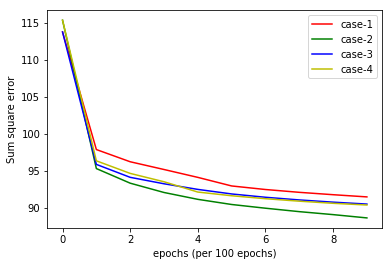

In [140]:
#plot data
epochs = [i for i in range(int(10000/1000))]
plt.plot(epochs,err_tss_1,'r',label='case-1')
plt.plot(epochs,err_tss_2,'g',label='case-2')
plt.plot(epochs,err_tss_3,'b',label='case-3')
plt.plot(epochs,err_tss_4,'y',label='case-4')
plt.legend(["case-1","case-2","case-3","case-4"])
plt.xlabel("epochs (per 100 epochs)")
plt.ylabel("Sum square error")

Text(0,0.5,'Sensitivity (TP)')

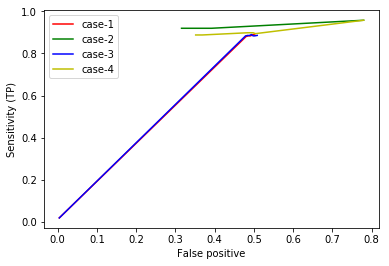

In [141]:
ind= np.argsort(specification_1)
specification_1 = np.array(specification_1)[ind] 
sensitivity_1= np.array(sensitivity_1)[ind]

ind= np.argsort(specification_2)
specification_2 = np.array(specification_2)[ind] 
sensitivity_2= np.array(sensitivity_2)[ind]

ind= np.argsort(specification_3)
specification_3 = np.array(specification_3)[ind] 
sensitivity_3= np.array(sensitivity_3)[ind]

ind= np.argsort(specification_4)
specification_4 = np.array(specification_4)[ind] 
sensitivity_4= np.array(sensitivity_4)[ind]
plt.plot(1-specification_1,sensitivity_1,'r',label='case-1')
plt.plot(1-specification_2,sensitivity_2,'g',label='case-2')
plt.plot(1-specification_3,sensitivity_3,'b',label='case-3')
plt.plot(1-specification_4,sensitivity_4,'y',label='case-4')
plt.legend(["case-1","case-2","case-3","case-4"])
plt.xlabel("False positive")
plt.ylabel("Sensitivity (TP)")